In [7]:
import galarp as grp
from galarp import InterpolatedWind, InterpolatedDensity

grp.pyplot_style()
cmap = grp.lavender_cmap(step_1=50)

import numpy as np

from astropy import units as u
from astropy.table import Table

from gala.units import galactic
from scipy.interpolate import interp1d

from matplotlib import pyplot as plt
from matplotlib import animation

from scipy import stats
from scipy.interpolate import interp1d

from astropy.modeling.models import Gaussian1D, custom_model
from astropy.modeling.fitting import LevMarLSQFitter

# Full dynamic shadowing

Shadowing occurs in ram pressure events when the disk (and other material) "gets in the way" of the ram pressure wind.
It manifests as a reduction of the wind downstream, as clouds work to limit the wind strength over time.

Examples of why this is important:

1. Face-on wind shadows have a higher *volume* than edge-on wind shadows. However, edge-on shadows must be **stronger**,
as the wind is passing through a higher column density of gas.


### How we do it

1. Apply a rotation matrix to our current particle distribution to align the particles with what the wind "sees"

2. Bin the particles by taking a 2D histogram along the wind's line of sight.

3. Determine the shadow using the clouds' z-positions (distance along LOS), using cumulative distribution functions.

This gives us a list of damping values for each cloud, without requiring us to rotating anything back into the original
frame.

In [8]:
orbits = grp.OrbitContainer.load("temp/orbits_JZ_dup.grp")

x,y,z, *_ = grp.get_orbit_data(orbits.data, transposed=False)

wind = grp.LorentzianWind(t0=300*u.Myr, width=200*u.Myr, units=galactic)
wind.init_from_inc(inclination=np.deg2rad(45), strength=800 * u.km/u.s)

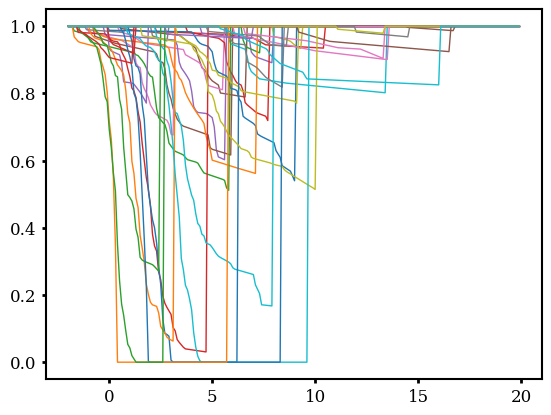

In [9]:
class DynamicShadow:

    def __init__(self, wind, depth=1e10, masses=None, **kwargs):
        self.depth = depth
        self.wind = wind

        self.masses = masses

        self.shadow_name = "Dynamic"

        self.y_range = kwargs.get("y_range", (-20, 20))
        self.z_range = kwargs.get("z_range", (-20, 20))
        self.n_bins = kwargs.get("n_bins", 20)

        self.x_range = kwargs.get("x_range", (-20, 50))
        self.n_bins_wind_direction = kwargs.get("n_bins_wind_direction", 101)

        self.debug = kwargs.get("debug", False)
        self.interps = []


    def evaluate(self, q, t):
        """
        Evaluate the shadowing effect on particles dynamically, by rotating particles to the wind-frame of reference
        and then computing line-of sight depths.

        NOTE: In the wind frame, the Y-Z plane is what the wind "sees", and the X-axis is the distance along the
        wind direction.

        Parameters:
        - q: numpy array, shape (3, N)
            Array of particle positions.
        - t: float
            Time parameter (Redundant for this shadow, but might be useful if we implement a changing wind inclination).

        Returns:
        - shadowing: numpy array, shape (N,)
            Array of shadowing values for each particle.
        """

        q = q.T

        # STEP 1: Rotate the particles to the wind frame    
        xyz_rotated = grp.rotate_yaxis(q, beta=self.wind.inclination())
        xyz_rotated_T = xyz_rotated.T


        shadowing = np.ones(len(q[0]))

        # STEP 2: Bin the particles along the y-z axis to get distribution along wind's line of sight
        # Create bins along the y and z axis
        y_bins = np.linspace(self.y_range[0], self.y_range[1], self.n_bins + 1)
        z_bins = np.linspace(self.z_range[0], self.z_range[1], self.n_bins + 1)

        # Bin particles along y-z axis
        y_bin_indices = np.digitize(xyz_rotated[1], y_bins)
        z_bin_indices = np.digitize(xyz_rotated[2], z_bins)

        bin_area = (y_bins[1] - y_bins[0]) * (z_bins[1] - z_bins[0])
        total_area = (self.y_range[1] - self.y_range[0]) * (self.z_range[1] - self.z_range[0])

        bin_area_ratio = bin_area / total_area

       # print(bin_area, total_area, bin_area_ratio)

        #shadow_bins = np.linspace(self.x_range[0], self.x_range[1], self.n_bins_wind_direction)

        # Get particles in the bin, and take only the z component
        # We take a cumulative sum of the histogram to get the integrated number of particles at each distance
        for i in range(self.n_bins):
            for j in range(self.n_bins):
                
                # Determine which particles are in this current bin              
                in_bin = np.bitwise_and(y_bin_indices == i + 1, z_bin_indices == j + 1)
                particles_in_z_bin = xyz_rotated_T[in_bin].T[0]
                sorted_indices = np.argsort(particles_in_z_bin)
                masses_in_bin = self.masses[in_bin]

                cumulative_mass = np.cumsum(masses_in_bin[sorted_indices])

                if len(cumulative_mass) == 0:
                    continue

                interp = interp1d(particles_in_z_bin[sorted_indices], 
                                  np.max((np.zeros(len(cumulative_mass)),
                                        1 - (cumulative_mass / depth / bin_area_ratio)), axis=0),
                                  kind="linear", fill_value=1, bounds_error=False, assume_sorted=True)
                
                # Get a cumulative histogram of the particle x directions and make it into an interp object
                # NOTE: This might be improved in the future to speed things up, but good for now

                # Apply shadowing to the particles in this bin
                shadowing[in_bin] = interp(xyz_rotated[0][in_bin])

                if self.debug:
                    self.interps.append(interp)

        return shadowing



    def debug_evaluate(self, q, t, **kwargs):
        shadowing = self.evaluate(q, t)

        size = kwargs.get("size", 1)

        outname = kwargs.get("outname", None)
        cmap = kwargs.get("cmap", "magma")

        fig, ax = plt.subplots(1, 3, figsize=(12, 5))

        m1 = ax[0].scatter(xyz[0], xyz[1], c=shadowing, cmap=cmap, s=size)
        ax[0].set(xlabel="X [kpc]", ylabel="Y [kpc]", xlim=(-20, 20), ylim=(-20, 20))

        m2 = ax[1].scatter(xyz[0], xyz[2], c=shadowing, cmap=cmap, s=size)
        ax[1].set(xlabel="X [kpc]", ylabel="Z [kpc]", xlim=(-20, 20), ylim=(-20, 20))

        m3 = ax[2].scatter(xyz[1], xyz[2], c=shadowing, cmap=cmap, s=size)
        ax[2].set(xlabel="Y [kpc]", ylabel="Z [kpc]", xlim=(-20, 20), ylim=(-20, 20))

        plt.colorbar(mappable=m1, ax=ax[0], label="Wind Strength", orientation="horizontal", location="top")
        plt.colorbar(mappable=m2, ax=ax[1], label="Wind Strength", orientation="horizontal", location="top")
        plt.colorbar(mappable=m3, ax=ax[2], label="Wind Strength", orientation="horizontal", location="top")

        plt.tight_layout()
        if outname is not None:
            plt.savefig(outname, dpi=kwargs.get("dpi", 200))
            plt.close()




sigmas = np.random.randint(6, 40, 10000)        
masses = np.random.uniform(1e5, 1e6, 10000)

depth = 5e10
inc = 45
for index in np.linspace(50, 400, 20).astype(int):
    xyz = np.array([x[index], y[index], z[index]])


    wind = grp.LorentzianWind(t0=300*u.Myr, width=200*u.Myr, units=galactic)
    wind.init_from_inc(inclination=np.deg2rad(inc), strength=800 * u.km/u.s)

    shadow = DynamicShadow(wind, depth=depth, n_bins=40, debug=True, masses=masses)
    shadow.evaluate(xyz.T, 0)
    #shadow.debug_evaluate(xyz.T, 0, outname=f"figures/shadowing_new/shadow_{index}_{depth}_{inc:.0f}.png", cmap="magma")

xs = np.arange(-2, 20, 0.1)
for interp in shadow.interps[:50]:
    plt.plot(xs, interp(xs))

#%timeit shadow.evaluate(xyz.T, 0)


## Testing sims with the dynamic shadow

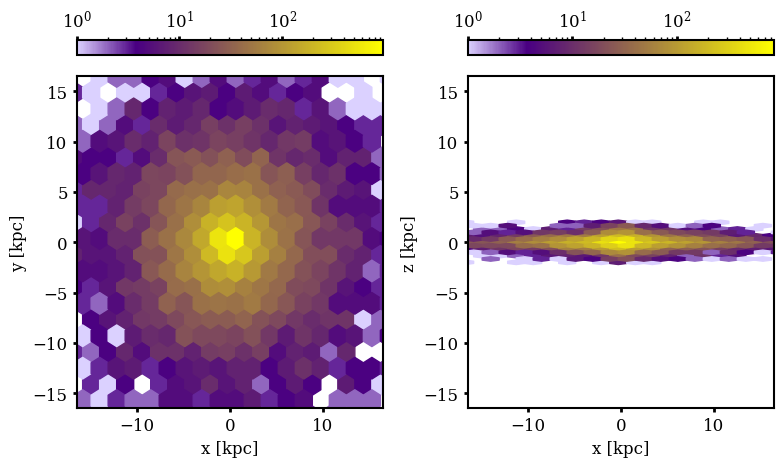

In [4]:
rb2006_satellite = grp.builtins.RB2006_Satellite()

mass_profile = grp.gen_mass_profile(rb2006_satellite)


particles = grp.ExponentialGrid(h_R=rb2006_satellite["gas"].parameters["a"],
                                h_z=rb2006_satellite["gas"].parameters["b"],
                                n_particles=10000)

particles.generate(mass_profile=mass_profile, positions="temp/positions_RB.npy")

particles.plot_density(cmap=cmap, gridsize=30)


In [5]:
orbit_containers = []
incs = [0, 15, 30, 60, 90]

for inclination in incs:

    rb2006_wind = grp.builtins.RB2006_Wind(inc=inclination)

    shadow = DynamicShadow(rb2006_wind, masses = np.random.uniform(1e5, 1e6, 10000), n_bins=20)

    sim = grp.RPSim(wind=rb2006_wind, potential=rb2006_satellite, shadow=shadow)

    orbits = sim.run(particles, integration_time=2000 * u.Myr, dt=5*u.Myr, printout=False, rho_icm=1e-26 * u.g/u.cm**3)
    orbit_containers.append(orbits)

10.0 solMass / pc2 10000
10000


 19%|█▉        | 76/399 [00:05<00:29, 10.80it/s]/Users/hsouchereau/galarp/galarp/rampressure.py:44: RuntimeWarning: overflow encountered in square
  a_ram = (np.pi * rho.evaluate(t) * r_cloud**2 / m_cloud).to(1 / u.kpc).value * (v_perp**2)
/Users/hsouchereau/gala/gala/integrate/pyintegrators/rk5.py:79: RuntimeWarning: invalid value encountered in multiply
  dw = dw + C[i]*K[i]
100%|██████████| 399/399 [00:42<00:00,  9.36it/s]


10.0 solMass / pc2 10000
10000


100%|██████████| 399/399 [00:35<00:00, 11.28it/s]


10.0 solMass / pc2 10000
10000


100%|██████████| 399/399 [00:36<00:00, 10.95it/s]


10.0 solMass / pc2 10000
10000


100%|██████████| 399/399 [00:37<00:00, 10.63it/s]


10.0 solMass / pc2 10000
10000


100%|██████████| 399/399 [00:33<00:00, 11.97it/s]


In [6]:
incs = [0, 15, 30, 45, 60, 75, 90]

for i, inclination in enumerate(incs):

    grp.animated_hexbin_plot(orbit_containers[i], outname=f"figures/rb2006_dynamic_shadow_{inclination}.gif", 
                             cmap=cmap, n_frames=200)

/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/astropy/units/core.py:1103: RuntimeWarning: overflow encountered in multiply
  return lambda val: scale * _condition_arg(val)
/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/matplotlib/axes/_axes.py:5001: RuntimeWarning: invalid value encountered in cast
  iy1 = np.round(iy).astype(int)
/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/matplotlib/axes/_axes.py:5003: RuntimeWarning: invalid value encountered in cast
  iy2 = np.floor(iy).astype(int)
/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/matplotlib/axes/_axes.py:5000: RuntimeWarning: invalid value encountered in cast
  ix1 = np.round(ix).astype(int)
/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/matplotlib/axes/_axes.py:5002: RuntimeWarning: invalid value encountered in cast
  ix2 = np.floor(ix).astype(int)
/Users/hsouchereau/galarp/galarp/postprocessing/analysis/disk_analysis.py:28: 

IndexError: list index out of range

/var/folders/gy/19m5w8qn3k10k6z5fvjf7byh0000gq/T/ipykernel_9258/1816796554.py:4: RuntimeWarning: overflow encountered in square
  r = np.sqrt(x**2 + y**2)
/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/astropy/units/core.py:1103: RuntimeWarning: overflow encountered in multiply
  return lambda val: scale * _condition_arg(val)


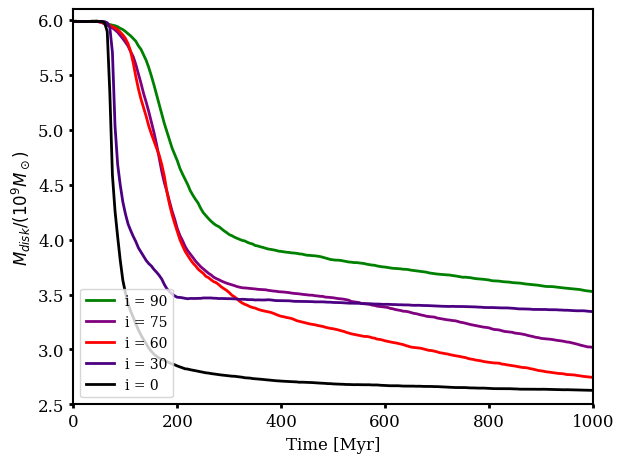

In [ ]:
def Mdisk(orbits, rmax = 27 * u.kpc, thickness=5 * u.kpc, **kwargs):
    x,y,z, vx, vy, vz = orbits.get_orbit_data(transposed=False)

    r = np.sqrt(x**2 + y**2)

    in_disk = np.logical_and(r < rmax.value, np.abs(z) < thickness.value)


    evol = np.sum(in_disk, axis=1) * orbits.metadata["M_CLOUD"].to(u.Msun).value
    
    return orbits.data.t, evol

incs = [0, 15, 30, 60, 90]


colors = ["black", "indigo", "red", "maroon", "green"]
colors = ["green", "purple", "red", "indigo", "black"]

for i, container in enumerate(orbit_containers):
    times, evol = Mdisk(container)
    plt.plot(times, evol * 6 / 1e9, color=colors[i], lw=2, label=f"i = {90 - incs[i]}")

plt.xlim(0, 1000)
plt.ylim(2.5, 6.1)

plt.ylabel("$M_{disk} / (10^9 M_\odot)$")
plt.xlabel("Time [Myr]")

plt.legend(fontsize=10, loc="lower left")
plt.tight_layout()
plt.savefig("figures/rb2006_dynamic_shadow_diskmass_evolution.png", dpi=200)

In [ ]:
orbit_containers_lorentzian = []
incs = [0, 15, 30, 60, 90]

for inclination in incs:

    wind = grp.LorentzianWind(t0=500*u.Myr, width=500*u.Myr, units=galactic)
    wind.init_from_inc(inclination=np.deg2rad(inclination), strength=800 * u.km/u.s)

    shadow = DynamicShadow(wind, masses = np.random.uniform(1e5, 1e6, 10000), n_bins=40)

    sim = grp.RPSim(wind=wind, potential=rb2006_satellite, shadow=shadow)

    orbits = sim.run(particles, integration_time=2000 * u.Myr, dt=5*u.Myr, printout=False, rho_icm=1e-26 * u.g/u.cm**3)
    orbit_containers_lorentzian.append(orbits)

10.0 solMass / pc2 10000
10000


100%|██████████| 399/399 [01:12<00:00,  5.51it/s]


10.0 solMass / pc2 10000
10000


100%|██████████| 399/399 [01:27<00:00,  4.55it/s]


10.0 solMass / pc2 10000
10000


100%|██████████| 399/399 [01:38<00:00,  4.04it/s]


10.0 solMass / pc2 10000
10000


100%|██████████| 399/399 [01:41<00:00,  3.93it/s]


10.0 solMass / pc2 10000
10000


100%|██████████| 399/399 [01:49<00:00,  3.64it/s]


/var/folders/gy/19m5w8qn3k10k6z5fvjf7byh0000gq/T/ipykernel_24863/1816796554.py:4: RuntimeWarning: overflow encountered in square
  r = np.sqrt(x**2 + y**2)
/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/astropy/units/core.py:1103: RuntimeWarning: overflow encountered in multiply
  return lambda val: scale * _condition_arg(val)


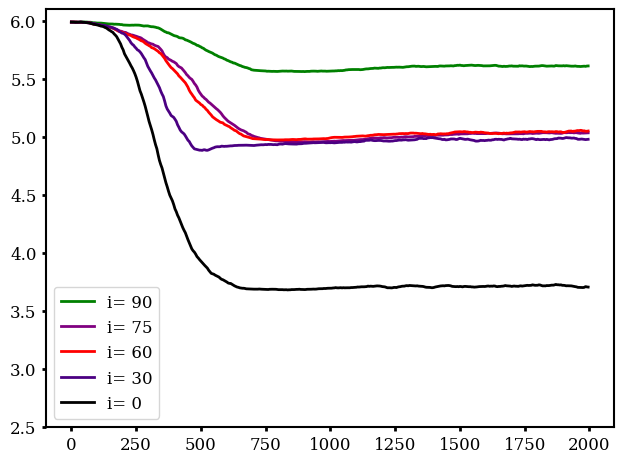

In [ ]:
for i, container in enumerate(orbit_containers_lorentzian):
    times, evol = Mdisk(container)
    plt.plot(times, evol * 6 / 1e9, label=f"i= { 90 - incs[i]}", color=colors[i], lw=2)

plt.ylim(2.5, 6.1)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def rstrip_rb2006(orbits, n_scanlines=12):
    x,y,z, *_ = orbits.get_orbit_data(transposed=False)

    r = np.sqrt(x**2 + y**2)
    thetas = np.arctan2(y, x)

    bins = np.linspace(0, 40, 100)
    areas = np.pi * (bins[1:]**2 - bins[:-1]**2)
    print(len(bins), len(areas))
    xs = np.arange(0, 100, 100)

    stripped_mins, stripped_maxes, stripped_means = [], [], []
    for i in range(0, len(x)):
        this_x, this_y = x[i], y[i]
        this_r = r[i]
        thetas = np.arctan2(this_y, this_x)

        stripped_vals = []
        for theta in np.arange(0, 360, 360 / n_scanlines):

            theta_rad = np.deg2rad(theta)
            delta_theta = 2 * np.pi / n_scanlines
            
            in_sector = np.logical_and(theta_rad < thetas, thetas < theta_rad + delta_theta)
            in_sector = np.logical_and(in_sector, np.logical_and(~np.isnan(this_r), this_r < 27))
            
            r_in_sector = this_r[in_sector]

            hist = np.histogram(r_in_sector, bins=bins)[0]
            hist = hist / areas
            this_stripped = np.argmax(hist < 0.1)

            stripped_vals.append(bins[this_stripped])

        stripped_vals = np.array(stripped_vals)
        stripped_mins.append(np.nanmin(stripped_vals))
        stripped_maxes.append(np.nanmax(stripped_vals))
        stripped_means.append(np.nanmean(stripped_vals))

    return np.array(stripped_mins), np.array(stripped_maxes), np.array(stripped_means)



/var/folders/gy/19m5w8qn3k10k6z5fvjf7byh0000gq/T/ipykernel_48811/933709529.py:4: RuntimeWarning: overflow encountered in square
  r = np.sqrt(x**2 + y**2)


100 99
100 99
100 99
100 99
100 99


(0.0, 1000.0)

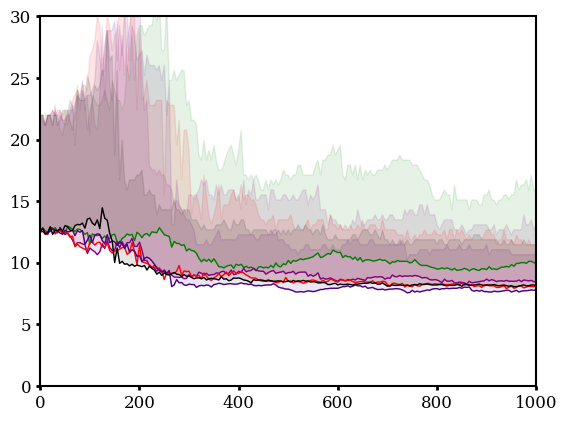

In [ ]:

floor = 5

for i, container in enumerate(orbit_containers):
    mins, maxes, medians = rstrip_rb2006(container)
    plt.plot(times, medians + floor, label=f"Inc: {incs[i]}", color=colors[i])
    plt.fill_between(times.value, medians + floor, maxes + floor, alpha=0.1, color=colors[i])
# plt.plot(times, medians, label="Mean")
# plt.fill_between(times.value, mins, maxes, alpha=0.5, label="Min-Max")

plt.ylim(0, 30)
plt.xlim(0, 1000)

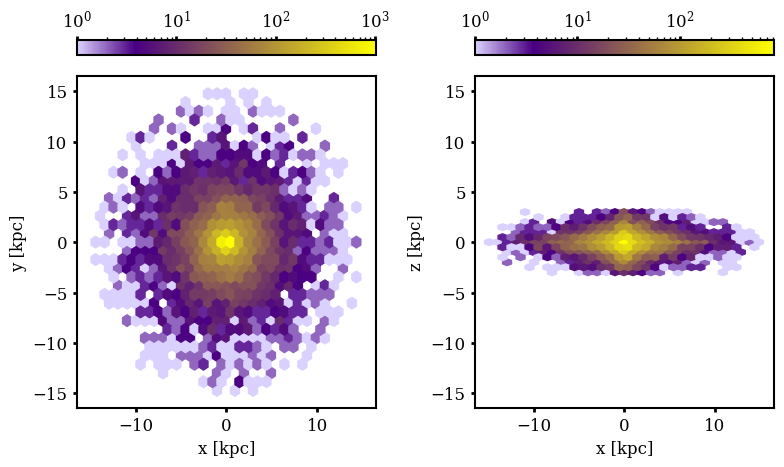

In [ ]:
jz_satellite = grp.builtins.JZ2023_Satellite()
mass_profile = grp.gen_mass_profile(jz_satellite)

particles = grp.ExponentialGrid(h_R=jz_satellite["gas"].parameters["a"],
                                h_z=jz_satellite["gas"].parameters["b"],
                                n_particles=10000)

particles.generate(mass_profile=mass_profile, positions="temp/positions.npy")

particles.plot_density(cmap=cmap, gridsize=30)


In [ ]:
orbit_containers_jz = []
incs = [0, 15, 30, 60, 90]

for inclination in incs:

    rb2006_wind = grp.builtins.RB2006_Wind(inc=inclination)

    shadow = DynamicShadow(rb2006_wind, masses = np.random.uniform(1e5, 1e6, 10000), n_bins=40, depth=1e10)

    sim = grp.RPSim(wind=rb2006_wind, potential=jz_satellite, shadow=shadow)

    orbits = sim.run(particles, integration_time=2000 * u.Myr, dt=5*u.Myr, printout=False, rho_icm=1e-26 * u.g/u.cm**3)
    orbit_containers_jz.append(orbits)


for i, container in enumerate(orbit_containers_jz):
    times, evol = Mdisk(container)
    plt.plot(times, evol * 6 / 1e9, label=f"i= { 90 - incs[i]}", color=colors[i], lw=2)

plt.ylim(2.5, 6.1)
plt.legend()
plt.tight_layout()
plt.show()

10.0 solMass / pc2 10000
10000


 22%|██▏       | 86/399 [00:21<01:17,  4.01it/s]


KeyboardInterrupt: 

In [ ]:
for i, inclination in enumerate(incs):

    grp.animated_hexbin_plot(orbit_containers_jz[i], outname=f"figures/jz_dup/jz2023_dynamic_shadow_{inclination}.gif", 
                             cmap=cmap, n_frames=200)

/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/matplotlib/axes/_axes.py:5001: RuntimeWarning: invalid value encountered in cast
  iy1 = np.round(iy).astype(int)
/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/matplotlib/axes/_axes.py:5003: RuntimeWarning: invalid value encountered in cast
  iy2 = np.floor(iy).astype(int)
/Users/hsouchereau/galarp/galarp/postprocessing/analysis/disk_analysis.py:28: RuntimeWarning: overflow encountered in square
  r = np.sqrt(x**2 + y**2 + z**2)
/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/matplotlib/axes/_axes.py:5010: RuntimeWarning: overflow encountered in square
  d1 = (ix - ix1) ** 2 + 3.0 * (iy - iy1) ** 2
/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/matplotlib/axes/_axes.py:5011: RuntimeWarning: overflow encountered in square
  d2 = (ix - ix2 - 0.5) ** 2 + 3.0 * (iy - iy2 - 0.5) ** 2
/Users/hsouchereau/galarp/galarp/postprocessing/analysis/disk_analysis.py:28: R

In [ ]:
v_ICM = 1200 * u.km / u.s
rho_ICM = 1e-26 * u.g / u.cm**3

tau_icm = 1 * u.Myr

width_ICM = height_ICM = 1 * u.kpc
length_ICM = 100 * u.pc

m_injected = (v_ICM * tau_icm * width_ICM * height_ICM * rho_ICM).to(u.Msun)

p_ICM = m_injected * v_ICM

print(m_injected)
print(p_ICM)



r_cloud = 100 * u.pc
interaction_time = (4 * r_cloud) / v_ICM
m_cloud = 1e6 * u.Msun

delta_p_cloud = (interaction_time * rho_ICM * v_ICM **2 * np.pi * r_cloud**2).to(u.km * u.solMass / u.s)



NameError: name 'u' is not defined

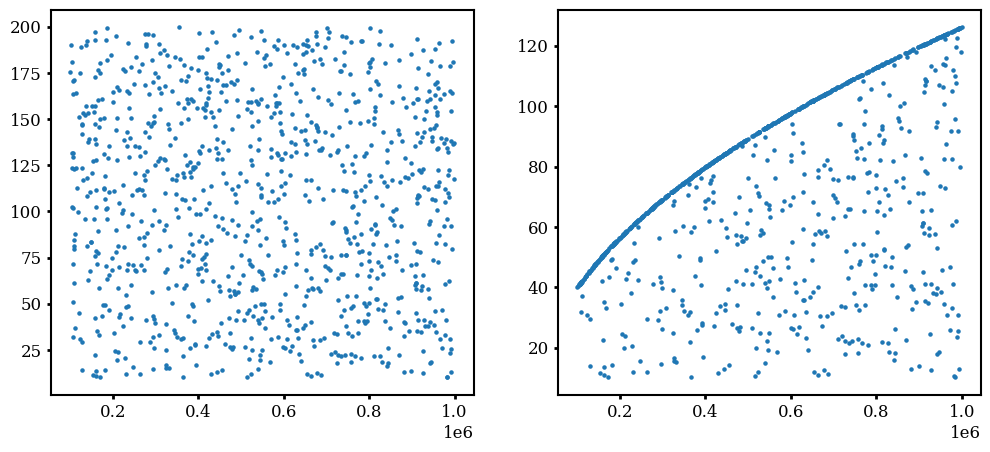

In [ ]:
sigma_crit = 20 * u.Msun / u.pc**2

n_clouds = 1000


r_clouds = np.random.uniform(10, 200, n_clouds) * u.pc
m_clouds = np.random.uniform(1e5, 1e6, n_clouds) * u.solMass

A_clouds = np.pi * r_clouds**2

A_clouds_eff = np.min([A_clouds, m_clouds / sigma_crit], axis=0)

r_clouds_eff = np.sqrt(A_clouds_eff / np.pi)

sigma_clouds = m_clouds / A_clouds



fig, ax = plt.subplots(1, 2, figsize=(12, 5))


ax[0].scatter(m_clouds, r_clouds, s=5)

ax[1].scatter(m_clouds, r_clouds_eff, s=5)


1.9230254483610655e+46 dyn s
Myr g / cm3 km / s pc2


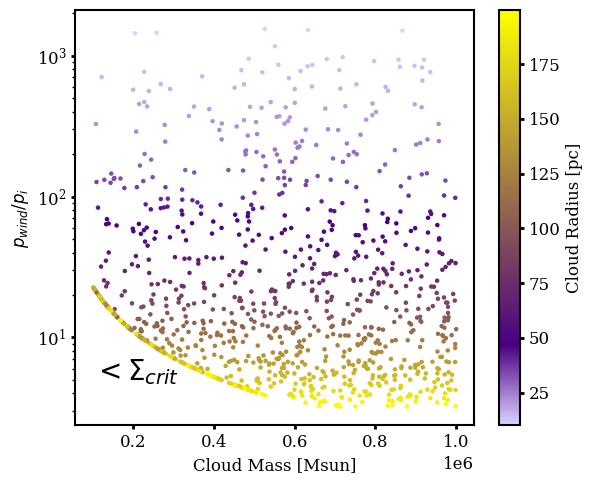

In [ ]:
sig_crit = 5 * u.Msun / u.pc**2

tau_wind = 1 * u.Myr

rho_ICM = 1e-26 * u.g / u.cm**3
v_wind = 800 * u.km / u.s

bin_width = 1 * u.kpc

p_wind = (tau_wind * rho_ICM * v_wind ** 2 * bin_width ** 2).cgs

n_clouds = 1000
r_clouds = np.random.uniform(10, 200, n_clouds) * u.pc
m_clouds = np.random.uniform(1e5, 1e6, n_clouds) * u.solMass
A_clouds = np.pi * r_clouds**2


A_clouds_eff = np.min([A_clouds, m_clouds / sig_crit], axis=0) * u.pc **2
r_clouds_eff = np.sqrt(A_clouds_eff / np.pi) 


print(p_wind)

taus = 2 * tau_wind + 2 * r_clouds_eff / v_wind

print(taus.unit, rho_ICM.unit, v_wind.unit, A_clouds_eff.unit)


p_clouds = (taus * rho_ICM * v_wind ** 2 * A_clouds_eff).cgs


plt.figure(figsize=(6, 5))
plt.scatter(m_clouds, p_wind / p_clouds, c=r_clouds.value, s=5, cmap=cmap)
plt.yscale("log")

plt.text(1e5, 5, "$< \Sigma_{crit}$", fontsize=20)

plt.xlabel("Cloud Mass [Msun]")
plt.ylabel("$p_{wind} / p_i$")
plt.tight_layout()
plt.colorbar(label="Cloud Radius [pc]")

plt.savefig("figures/wind_momentum_loss.pdf", dpi=200)